In [26]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

In [44]:
#import sys
#sys.path.insert(1, "../src/utils")
#import plots as p
sn.set_theme(
    context="paper",
    style="whitegrid",
    font_scale=1.8,
    rc={"lines.linewidth": 2},
    palette="tab10",
)
dpi = 300

In [28]:
df = pd.read_csv("../src/data/data_oct20.csv").fillna(0)
df = df.rename(columns = {"L": "Load", 
                          "Wind_speed": "Wind Speed", 
                          "Temperature": "Air Temp",
                          "Global_irradiance": "GHI", 
                          "Plane_irradiance": "PAI", 
                          "Module_temp": "Module Temp"})
df.head(2)

,L2_react,L2,Load,L_react,NS4949_export,L2_active_import,PV,Wind Speed,Air Temp,GHI,PAI,Module Temp,Bat_current,Bat_energy,Battery_SOC,Battery_voltage,Battery_charge,Battery_discharge,date,L1
0,-1.672253,8.917166,105.823796,-1.330095,103.75,7.5,0.003709,5.0,1.885714,0.017964,0.018072,0.000171,-0.181818,762.249603,69.649998,751.549988,0.000042,0.000031,2020-10-01 01:00:00,96.906629
1,-1.672253,8.917166,105.823796,-1.330095,103.75,7.5,0.003709,5.0,1.885714,0.017964,0.018072,0.000171,-0.181818,762.249603,69.649998,751.549988,0.000042,0.000031,2020-10-01 01:01:00,96.906629


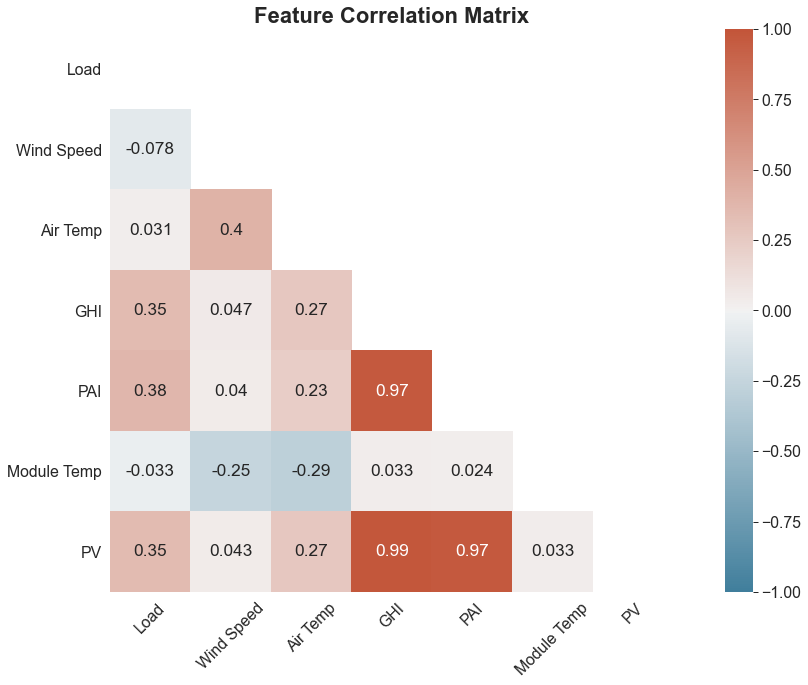

In [29]:
corr = df.filter([ "Load", "Wind Speed", "Air Temp",  "GHI", "PAI",  "Module Temp", "PV"]).corr()
plt.figure(figsize = (15,10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sn.diverging_palette(230, 20, as_cmap=True)

g = sn.heatmap(corr, mask=mask, vmin = -1, vmax = 1, center = 0, annot=True, square=True, cmap = cmap)#'RdBu')
sn.set(style="white", font_scale= 1.9)
plt.xticks(rotation = 45)

plt.title("Feature Correlation Matrix", fontsize = 22, fontweight = "bold")
plt.tight_layout() 
plt.savefig("../figs/feature_corr.eps", format = "eps", dpi = dpi)
plt.show()

In [30]:
from statsmodels.graphics.tsaplots import plot_acf

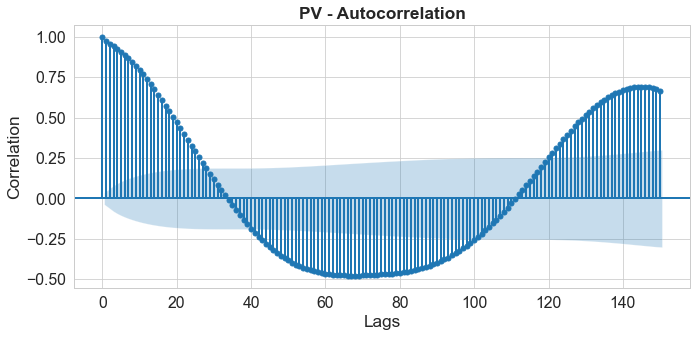

In [31]:
df_new = pd.read_csv("../src/data/8.4_cleaned.csv", parse_dates =["date"]).fillna(0).set_index("date")
sn.set_theme(
    context="paper",
    style="whitegrid",
    font_scale=1.8,
    rc={"lines.linewidth": 2},
    palette="tab10",
)

#df_auto = df[df["PV"] > 4].reset_index()
_, ax = plt.subplots(figsize =(10,5))
plot_acf(df_new["PV"], lags = 150, ax = ax, alpha = 0.05)
ax.set_title("PV - Autocorrelation", fontweight = "bold")
ax.set_xlabel("Lags")
ax.set_ylabel("Correlation")
plt.tight_layout() 
plt.savefig("../figs/pv_autocorr.pdf", format = "pdf", dpi = dpi)
plt.show()

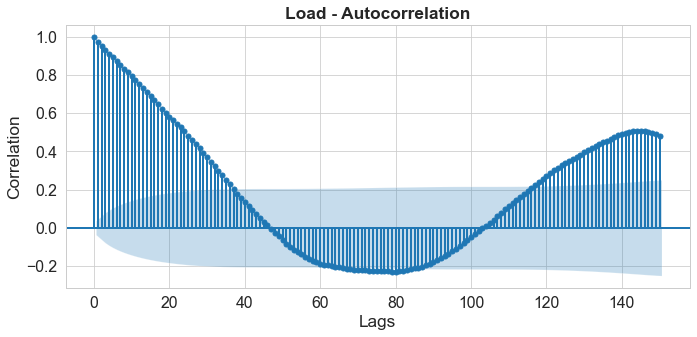

In [32]:
_, ax = plt.subplots(figsize =(10,5))
plot_acf(df_new["L"], lags = 150, ax = ax, alpha = 0.05)
ax.set_title("Load - Autocorrelation", fontweight = "bold")
ax.set_xlabel("Lags")
ax.set_ylabel("Correlation")
plt.tight_layout() 
plt.savefig("../figs/load_autocorr.pdf", format = "pdf", dpi = dpi)
plt.show()

In [33]:

def get_predictions(df, timestamp):
    return df[df["collected"] == timestamp]
def plot_prediction(df):
    fig, ax = plt.subplots(figsize = (10,5))
    plt.plot(df.index, df["GHI"])
    plt.fill_between(df.index, df["GHI10"], df["GHI90"], alpha = 0.5, color = "pink")
    time = df.iloc[0]["collected"].strftime("%d %B, %H.%M")
    plt.title("GHI forecast with 90% confidence interval - {}".format( time), fontweight = "bold")
    ax.xaxis.set_major_locator(mdates.HourLocator(interval = 3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H.%M'))
    plt.xlabel("Time")
    #sn.set(style="white", font_scale= 1.9)
    plt.ylabel("GHI")
    plt.tight_layout() 
    plt.savefig("../figs/solcast_example.pdf", format="pdf", dpi = dpi)

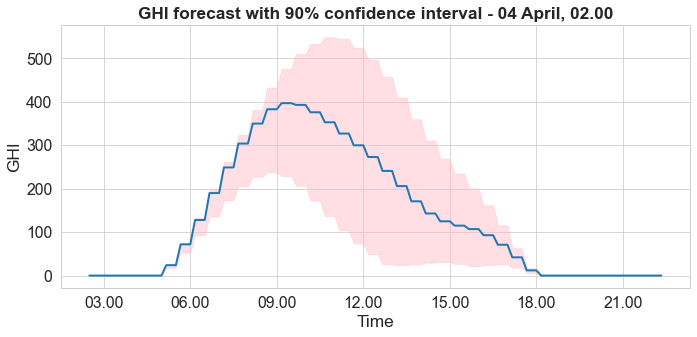

In [34]:
solcast = pd.read_csv("../src/data/solcast_cleaned.csv", parse_dates = ["time", "collected"]).set_index(["time"])


plot_prediction(get_predictions(solcast, datetime(2021, 4, 4, hour = 2)))

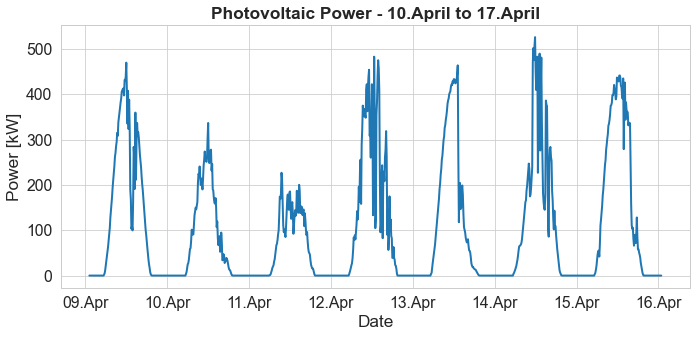

In [48]:
data = pd.read_csv("../src/data/23.4_cleaned.csv", parse_dates = ["date"]).fillna(0).set_index("date")

def plot_days(df, month, day, signal, title = "", n_days = 3, ax = None, interval = 24):
    if not ax: 
        plt.figure(figsize = (10, 5))
        ax = plt.gca()
    start_date = datetime(2021, month, day)
    end_date = start_date + timedelta(days=n_days)

    data_plot = data[(data.index > start_date) & (data.index < end_date)]
    ax.xaxis.set_major_locator(mdates.HourLocator(interval = interval))
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%b'))
    ax.plot(data_plot[signal], lw = 2)

    ax.set_title("{} - {} to {}".format(title, start_date.strftime("%d.%B"),end_date.strftime("%d.%B") ), fontweight = "bold")
    ax.set_ylabel("Power [kW]")
    ax.set_xlabel("Date")

month = 4
day = 10
n_days = 7
#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))
plot_days(data, month, day, "PV", title = "Photovoltaic Power", ax = None, n_days = n_days)
#plot_days(data, month, day, "L", title = "b) - Load Power", ax = ax2, n_days = n_days)
plt.tight_layout()
plt.savefig("../figs/PV-example.pdf", format = "pdf", dpi = dpi)

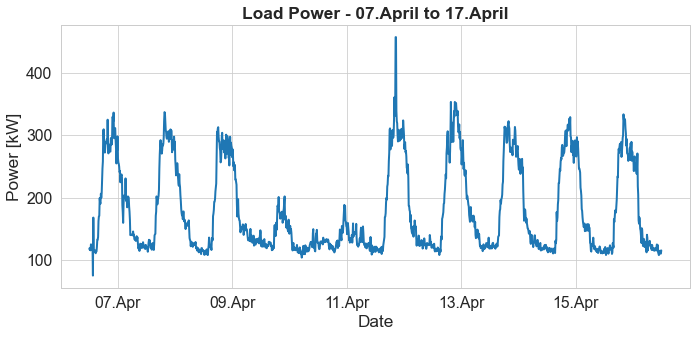

In [36]:
month = 4
day = 7
n_days = 10
plot_days(data, month, day, "L", title = "Load Power", ax = None, n_days = n_days, interval = 48)
plt.tight_layout()
plt.savefig("../figs/load_example.pdf", format = "pdf", dpi = dpi)

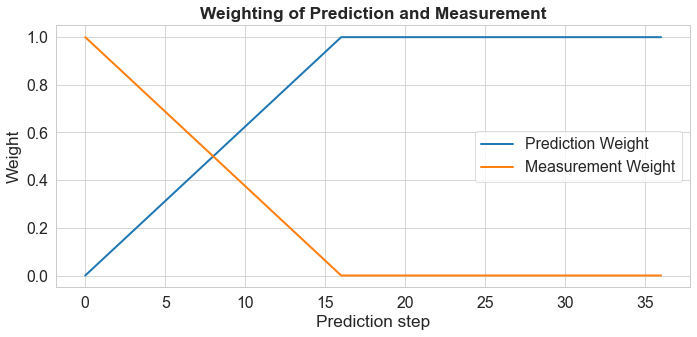

In [37]:
sn.set_theme(
    context="paper",
    style="whitegrid",
    font_scale=1.8,
    rc={"lines.linewidth": 2},
    palette="tab10",
)

pred = np.ones(36)
pred_weight = np.append(np.linspace(0, 1, 16 + 1), np.ones(len(pred) - 16))
measurement_weight = np.append( np.linspace(1, 0, 16 + 1), np.zeros(len(pred) - 16))

plt.figure(figsize=(10, 5))
plt.plot(pred_weight, label = "Prediction Weight")
plt.plot(measurement_weight, label = "Measurement Weight")
plt.legend()
plt.title("Weighting of Prediction and Measurement", fontweight = "bold")
plt.xlabel("Prediction step")
plt.ylabel("Weight")
plt.tight_layout()
plt.savefig("../figs/linear_mixture.pdf", format="pdf", dpi = dpi)
plt.show()

## Greenhouse emissions

In [38]:
sectors = ["Oil and Gas Extraction", "Heating", "Industry and Mining", "Energy Supply",  "Road Traffic", "Avitaion, navigation etc.", "Agriculture", "Others"]
emissions = [14.0, 1.0, 11.6, 1.6, 8.5, 6.9, 4.4, 2.3]
emissions_world = []
em = pd.DataFrame(data= {"Sectors": sectors, "CO2": emissions})
em

,Sectors,CO2
0,Oil and Gas Extraction,14.0
1,Heating,1.0
2,Industry and Mining,11.6
3,Energy Supply,1.6
4,Road Traffic,8.5
5,"Avitaion, navigation etc.",6.9
6,Agriculture,4.4
7,Others,2.3


In [39]:
em["CO2"] = pd.to_numeric(em["CO2"])
em["CO2_per"] = em["CO2"]/em["CO2"].sum()

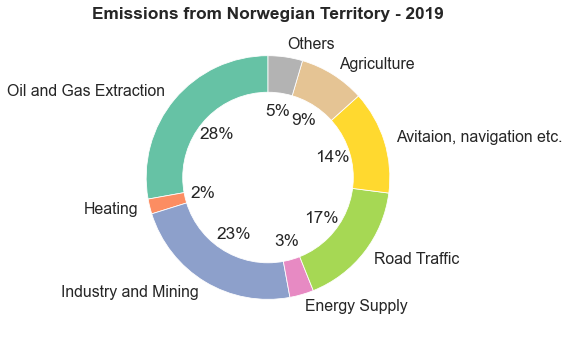

In [40]:
sn.set_theme(
    context="paper",
    style="white",
    font_scale=1.8,
    rc={"lines.linewidth": 2},
    palette="Set2",
)

def create_piechart(data, label, title = "", savepath=""):
    plt.figure(figsize =(10,5))
    plt.pie(data, labels = label, labeldistance = 1.1, startangle = 90, autopct='%1.0f%%', pctdistance = 0.55)

    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.title(title, fontweight="bold")
    plt.tight_layout()
    plt.savefig(savepath, format = "pdf", dpi = dpi)

create_piechart(em["CO2_per"], em["Sectors"], title ="Emissions from Norwegian Territory - 2019", savepath ="../figs/emissions_norway.pdf")
plt.show()

In [41]:
sources = ["Other \nRenewables","Solar","Wind", "Hydro","Nuclear", "Oil", "Gas", "Coal"]
values_world = [702.89, 844.39, 1590.19, 4355, 2616, 1128.4, 5892.3, 8735]
values_norway = np.asarray([0.01, 0, 0.092, 0.898, 0, 0, 0, 0])*100

pp = pd.DataFrame(data = {"Norway":values_norway, "World":values_world, "Source": sources}).set_index("Source")
pp["World"] = (pp["World"]/pp["World"].sum())*100
pp

,Norway,World
Source,,
Other \nRenewables,1.0,2.717621
Solar,0.0,3.264709
Wind,9.2,6.148235
Hydro,89.8,16.837965
Nuclear,0.0,10.114378
Oil,0.0,4.362792
Gas,0.0,22.781709
Coal,0.0,33.772590


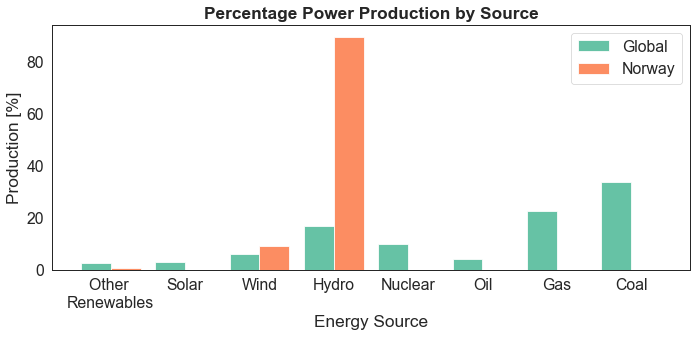

In [42]:
ind = np.arange(pp.shape[0])
width = 0.4
plt.figure(figsize = (10,5))
plt.bar(ind, pp.World, width=width)
plt.bar(ind+width, pp.Norway, width=width)
"""
for i, v in enumerate(pp.World):
    plt.text(ind[i]-width/2, v, str(int(np.around(v)))+"%", color='k')
    
for i, v in enumerate(pp.Norway):
    plt.text(ind[i]+width/2, v, str(int(np.around(v)))+"%", color='k')
"""

plt.xticks(ind + width/2, labels=pp.index)
plt.title("Percentage Power Production by Source", fontweight="bold")
plt.legend(["Global", "Norway"])
plt.xlabel("Energy Source")
plt.ylabel("Production [%]")
plt.tight_layout()
plt.savefig("../figs/energy_production.pdf",format="pdf", dpi = dpi)
plt.show()
